Financial Data Analysis

IMPORTING IMPORTANT LIBRARIES

In [14]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import nltk
import textblob
import talib as ta

In [15]:
import talib as ta
import sys
import os


sys.path.append(os.path.abspath("../scripts"))
from utils import *
from language_processing import *

data_utils = DataUtils()
LangProcess = LanguageProcessing()

EXPLORATORY DATA ANALYSIS

IMPORTING DATASET

In [16]:
news = data_utils.load_news_data()

In [37]:
news.head()

,headline,url,publisher,stock,headline length
date,,,,,
2020-06-05 14:30:54+00:00,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,A,7
2020-06-03 14:45:20+00:00,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,A,7
2020-05-26 08:30:07+00:00,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,A,5
2020-05-22 16:45:06+00:00,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,A,7
2020-05-22 15:38:59+00:00,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,A,14


In [18]:
news.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1407328 entries, 2020-06-05 14:30:54+00:00 to 2011-05-12 04:00:00+00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   stock      1407328 non-null  object
dtypes: object(4)
memory usage: 53.7+ MB


In [19]:
news.shape

(1407328, 4)

In [20]:
news.isnull().sum()

headline     0
url          0
publisher    0
stock        0
dtype: int64

In [21]:
news[news.duplicated()]

,headline,url,publisher,stock
date,,,,
2015-07-07 04:00:00+00:00,API Tech Reports Q2 Loss $0.08 Vs Exp Loss $0....,https://www.benzinga.com/news/earnings/15/07/5...,Eddie Staley,ATNY
2015-07-01 04:00:00+00:00,"Top Performing Industries For July 1, 2015",https://www.benzinga.com/news/15/07/5642290/to...,Lisa Levin,GME


In [22]:
news["headline length"] = news["headline"].apply(lambda x: len(x.split()))

In [23]:
news.describe()

,headline length
count,1.407328e+06
mean,1.141671e+01
std,6.352997e+00
min,1.000000e+00
25%,7.000000e+00
50%,1.000000e+01
75%,1.300000e+01
max,7.700000e+01


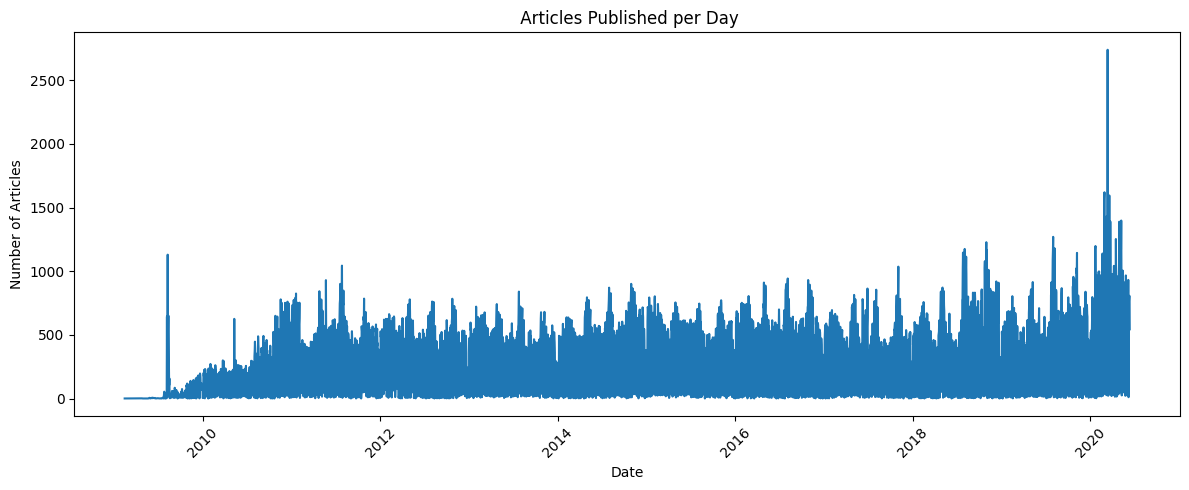

In [49]:

news['only_date'] = news['date'].dt.date


daily_counts = news['only_date'].value_counts().sort_index()


plt.figure(figsize=(12, 5))
daily_counts.plot(kind='line')
plt.title(" Articles Published per Day")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21356\627902127.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21356\627902127.py:13: UserWarning:

Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.

c:\Users\Lenovo\Stock Analysis\Stock_Analysis\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.



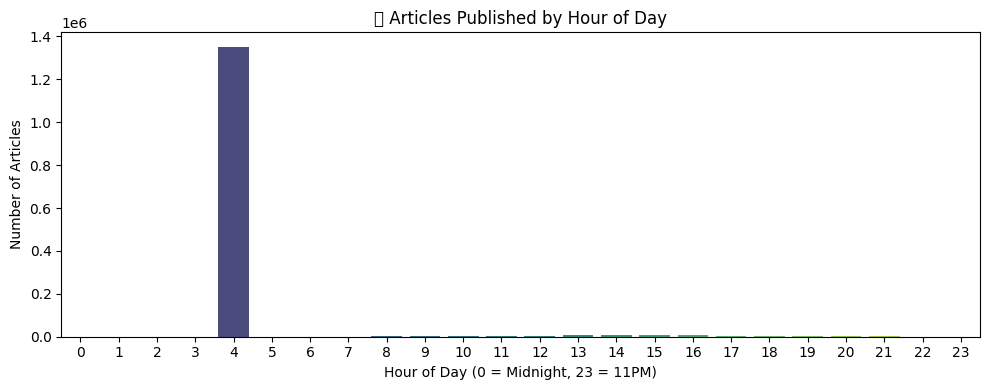

In [51]:

news['hour'] = news['date'].dt.hour


hourly_counts = news['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette="viridis")
plt.title("🕒 Articles Published by Hour of Day")
plt.xlabel("Hour of Day (0 = Midnight, 23 = 11PM)")
plt.ylabel("Number of Articles")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


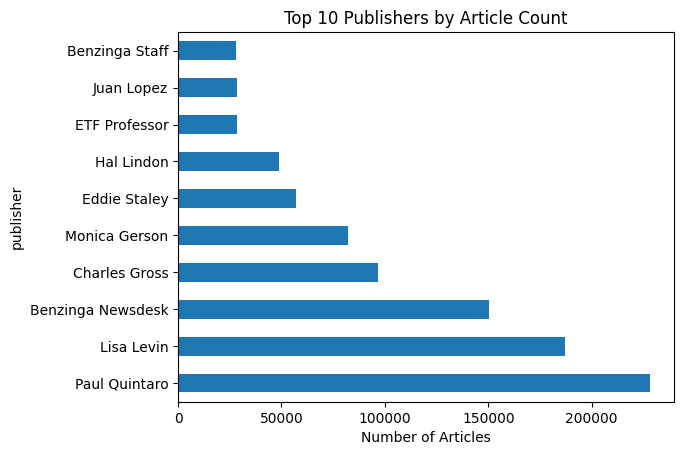

In [33]:
publisher_counts = news['publisher'].value_counts()
print(publisher_counts.head(10))  # Top 10 publishers

# Visualize
publisher_counts.head(10).plot(kind='barh', title='Top 10 Publishers by Article Count')
plt.xlabel("Number of Articles")
plt.show()


In [28]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)
X = vectorizer.fit_transform(news['headline'].dropna())


keywords = vectorizer.get_feature_names_out()
print("Top keywords:", keywords)

Top keywords: ['announces' 'benzinga' 'buy' 'downgrades' 'earnings' 'eps' 'est' 'market'
 'mid' 'price' 'pt' 'reports' 'sales' 'shares' 'stocks' 'top' 'trading'
 'update' 'vs' 'week']


In [38]:
news.columns = news.columns.str.strip() 

In [ ]:
news = news.reset_index()

print(news.columns.tolist()) 


['date', 'headline', 'url', 'publisher', 'stock', 'headline length']


Top email domains:
 email_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21356\2866250869.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



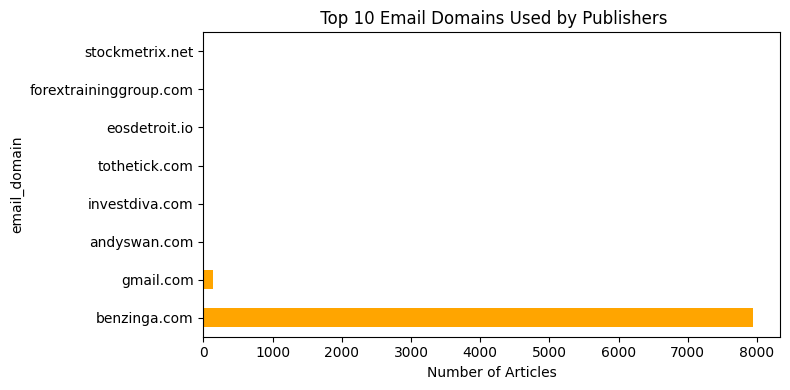

In [48]:

email_publishers = news[news['publisher'].str.contains('@', na=False)]


email_publishers['email_domain'] = email_publishers['publisher'].str.split('@').str[-1]


domain_counts = email_publishers['email_domain'].value_counts().head(10)

print("Top email domains:\n", domain_counts)

# Plot
plt.figure(figsize=(8, 4))
domain_counts.plot(kind='barh', color='orange')
plt.title(" Top 10 Email Domains Used by Publishers")
plt.xlabel("Number of Articles")
plt.tight_layout()
plt.show()
